In [1]:
import pandas as pd
import os
import torch
from IPython.display import display, Audio
import librosa
import math
import numpy as np
import scipy
from scipy import signal as sci_signal
import cv2
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
import pytorch_lightning as pl
import albumentations as albu
from torchvision.models import efficientnet
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pandas as pd
import pandas.api.types
import sklearn.metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from torch.utils.data import WeightedRandomSampler
        

In [2]:
class CONFIG:
    
    # == GENERAL ==
    seed = 13                             # random seed
    device = 'cuda'                         # device to be used
    mix_precision = False                   # whether to use mixed-16 precision
    
    # == DATA ==
    preprocess = True
    preprocessed_data = '../../preprocessed_data/imgs_v0/'                  # Path for processed data to be stores (Must put on .gitignore to not send to repo)
    checkpoint_dir = '../chpks/effnet_mixup_backgroundnoise'  # Checkpoints path (Must put on .gitignore to not send to repo)
    data_dir_2024 = '../../data/2024'# root folder
    sr = 32000                              # sampling rate
    n_fft = 1095                            # NFFT of Spec.
    win_len = 412                           # WIN_SIZE of Spec.
    hop_len = 100                           # overlap of Spec.
    min_freq = 100                           # min frequency
    max_freq = 16000                        # max frequency
    
    # == MODEL ==
    model = 'efficientnet_b0'               # model architecture
    
    # == DATASET ==
    batch_size = 32                         # batch size of each step
    n_workers = 4                           # number of workers
    
    # == AUG ==
    USE_HORIZFLIP = True
    USE_XYMASKING = True                    # whether use XYMasking

    # == TRAINING ==
    folds = 5                               # n fold
    epochs = 4                         # max epochs
    lr = 1e-3                               # learning rate
    weight_decay = 1e-5                     # weight decay of optimizer
    visualize = True                        # whether to visualize data and batch

In [3]:
df = pd.read_csv("only_pl_no_dups_5sec_leq20.csv")
df.head()

# Labels
label_list = sorted(df['label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

train_df = df[['label', 'wav_path']].copy()  # Uses only audio, label and rating.

# Create Target
train_df['target'] = train_df.label.map(label2id)

# Create Filepath
# train_df['filepath'] = CONFIG.data_dir_2024 + '/train_audio/' + train_df.filename

# Create Name
train_df['name'] = train_df.wav_path.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

In [4]:
def preprocess_fn(filepath, input_audio = None):

    # LOAD .OGG
    if(input_audio is None):
        input_audio, _ = librosa.load(filepath, sr=CONFIG.sr)
    else:
        input_audio = input_audio
        
    # HANDLE NaNs
    mean_signal = np.nanmean(input_audio)
    input_audio = np.nan_to_num(input_audio, nan=mean_signal) if np.isnan(input_audio).mean() < 1 else np.zeros_like(input_audio)
    
    # SPECTROGRAM
    frequencies, times, spec_data = sci_signal.spectrogram(
        input_audio, 
        fs=CONFIG.sr, 
        nfft=CONFIG.n_fft, 
        nperseg=CONFIG.win_len, 
        noverlap=CONFIG.hop_len, 
        window='hann'
    )
    
    # FILTER LOWER AND HIGHER FREQUENCIES
    valid_freq = (frequencies >= CONFIG.min_freq) & (frequencies <= CONFIG.max_freq)
    spec_data = spec_data[valid_freq, :]
    
    # COMPUTE LOG SPEC
    spec_data = np.log10(spec_data + 1e-20)
    
    # MIN/MAX NORMALIZATION
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()

    
#     print(spec_data.shape)
    # SPEC TO IMAGE
    spec_data = cv2.resize(spec_data, (256, 256), interpolation=cv2.INTER_AREA)
    
    return spec_data

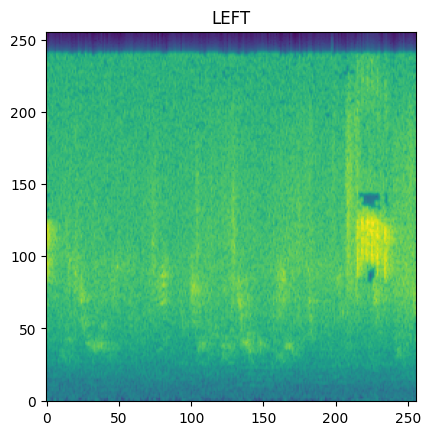

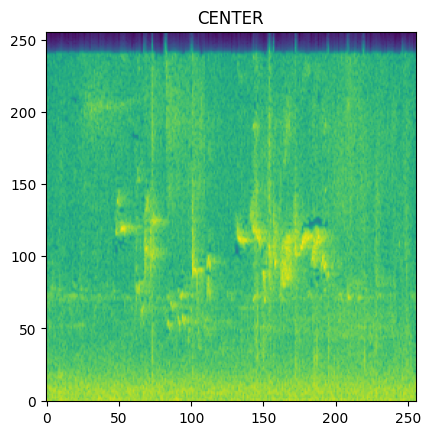

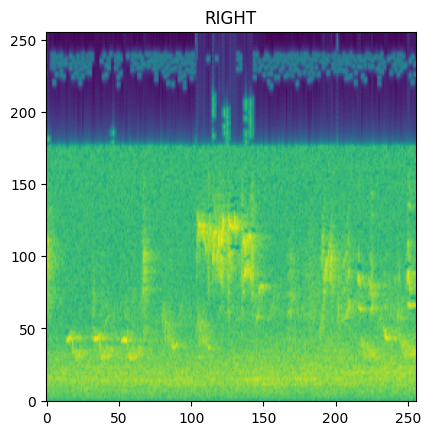

In [5]:
# Just testing

processed_spec_left = preprocess_fn(train_df['wav_path'].values[0])
processed_spec_center = preprocess_fn(train_df['wav_path'].values[1])
processed_spec_right = preprocess_fn(train_df['wav_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [31]:
list_augs = os.listdir('../../preprocessed_data/5sec_unlabeleds_center/')
list_augs = ['../../preprocessed_data/5sec_unlabeleds_center/' + w for w in list_augs]

ex_df = pd.DataFrame({'wav_path': list_augs})

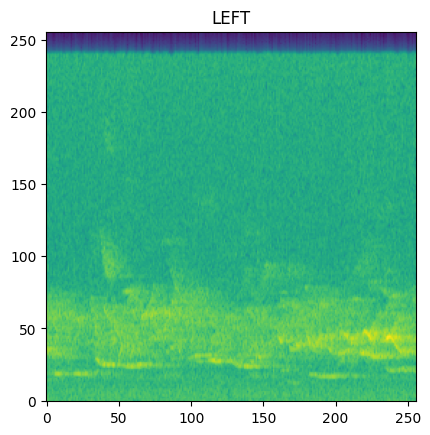

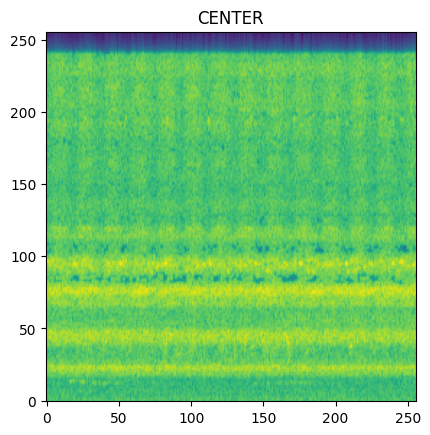

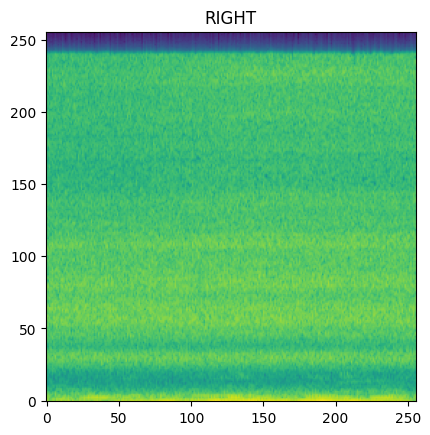

In [32]:
# Just testing

processed_spec_left = preprocess_fn(ex_df['wav_path'].values[0])
processed_spec_center = preprocess_fn(ex_df['wav_path'].values[1])
processed_spec_right = preprocess_fn(ex_df['wav_path'].values[2])

plt.figure()
plt.title('LEFT')
plt.imshow(processed_spec_left, origin='lower')
plt.show()

plt.figure()
plt.title('CENTER')
plt.imshow(processed_spec_center, origin='lower')
plt.show()

plt.figure()
plt.title("RIGHT")
plt.imshow(processed_spec_right, origin='lower')
plt.show()

In [33]:
train_df['is_train'] = 1
ex_df['is_train'] = 0

cols = ['wav_path', 'is_train']

ex_df_train, ex_df_val = train_test_split(ex_df, test_size = 444, random_state = 42)

df_full = pd.concat([train_df[cols].sample(8000, random_state = 42), ex_df_train[cols]]).reset_index(drop = True)
df_full.head()

wav_path  is_train
0  ../../preprocessed_data/5sec_wavs/rufwoo2_XC42...         1
1  ../../preprocessed_data/5sec_wavs/asikoe2_XC50...         1
2  ../../preprocessed_data/5sec_wavs/brnhao1_XC38...         1
3  ../../preprocessed_data/5sec_wavs/grywag_XC390...         1
4  ../../preprocessed_data/5sec_wavs/blrwar1_XC56...         1

In [34]:
df_full.is_train.value_counts()

1    8000
0    8000
Name: is_train, dtype: int64

In [189]:
import random
class BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.wav_path.values[numero_aleatorio]
        noise, sample_rate = librosa.load(noise_path, sr = None)
        
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / (1+rand_scale)

        return noisy_speech
    
class Torch_BackgroundAugmentation(object):
    def __init__(self, min_scale, max_scale, back_df):
        self.min_scale = min_scale
        self.max_scale = max_scale
        self.backgrounds = back_df

    def __call__(self, waveform):
        numero_aleatorio = random.randint(0, len(self.backgrounds)-1)
        noise_path = self.backgrounds.wav_path.values[numero_aleatorio]
        noise, sample_rate = torchaudio.load(noise_path)
        
        rand_scale = random.uniform(self.min_scale, self.max_scale)
#         print(rand_scale)
        noisy_speech = (rand_scale * waveform + noise) / (1+rand_scale)

        return noisy_speech

In [190]:
backaud = BackgroundAugmentation(0.5,0.5, ex_df_val)

In [191]:
ex = train_df['wav_path'].values[2]

Audio(ex)

In [192]:
waveform, sample_rate = librosa.load(ex, sr = None)
waveform = backaud(waveform)
Audio(waveform, rate = sample_rate)

In [225]:
tbackaud = Torch_BackgroundAugmentation(0.5, 0.5, ex_df_val)

In [226]:
waveform, sample_rate = torchaudio.load(ex)
waveform = tbackaud(waveform)
Audio(waveform, rate = sample_rate)

# Testing derivative of spectrogram

In [227]:
ex_df_val.wav_path.values[:3]

array(['../../preprocessed_data/5sec_unlabeleds_center/1832983968.wav',
       '../../preprocessed_data/5sec_unlabeleds_center/407311054.wav',
       '../../preprocessed_data/5sec_unlabeleds_center/823395316.wav'],
      dtype=object)

In [228]:
ex = train_df['wav_path'].values[2]

Audio(ex)

In [229]:
ex_noise = ex_df_val['wav_path'].values[-1]

Audio(ex_noise)

In [332]:
import torchaudio

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 1024,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}


def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V

def get_spectrogram(audio_path, use_b = False):
    waveform, sample_rate = torchaudio.load(audio_path, normalize=True)
    if(use_b):
        waveform = tbackaud(waveform)
    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(waveform)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)
    display(Audio(waveform, rate=sample_rate))
    print(spectrogram.mean())
    return spectrogram[0]

import torchaudio
def get_diff_spectrogram(audio_path, shifts=1, block_size=400, use_b = False):
    waveform, sample_rate = torchaudio.load(audio_path, normalize=True)
    if(use_b):
        waveform = tbackaud(waveform)
    transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
    spectrogram = transform(waveform)
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    spectrogram = db_transform(spectrogram)
    
    
#     remainder = spectrogram.shape[-1] % block_size
#     if remainder != 0:
#         pad_size = block_size - remainder
#     else:
#         pad_size = 0
    pad_size = shifts
    padded_specgram = torch.nn.functional.pad(spectrogram, (0, pad_size))
    
#     num_blocks = padded_specgram.shape[-1] // block_size
#     specgram_blocks = padded_specgram.view(padded_specgram.shape[0], padded_specgram.shape[1], num_blocks, block_size)
    
    
#     print(padded_specgram.shape)
#     specgram_derivative = torch.diff(specgram_blocks, dim=-1, n=shifts) 
    specgram_derivative = torch.diff(padded_specgram, dim=-1, n=shifts) 
#     specgram_derivative = specgram_derivative.view(padded_specgram.shape[0], padded_specgram.shape[1], -1)
    
#     specgram_shifted = torch.roll(spectrogram, shifts=-shifts, dims=-1)[:, :, :-shifts]
    
#     print(specgram_derivative.shape, specgram_shifted.shape)
#     specgram_relative_derivative = specgram_derivative / specgram_shifted
    
    
    norm_ = normalize_melspec(spectrogram)
    print(norm_.mean(), spectrogram.mean())
    display(Audio(waveform, rate=sample_rate))
    print(specgram_derivative.mean())
    return specgram_derivative[0], spectrogram[0]

In [333]:
k = -10

tensor(0.5373) tensor(-63.2019)


tensor(0.2173)


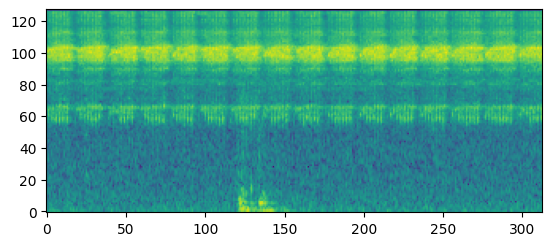

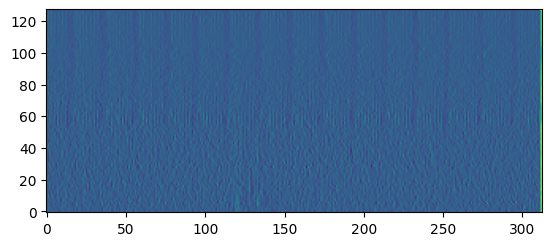

In [334]:
x1, x2 = get_diff_spectrogram(ex_df_val['wav_path'].values[k], 1)
plt.imshow(x2, origin='lower')
plt.show()
plt.imshow(x1, origin='lower')

tensor(0.1251) tensor(-92.5143)


tensor(0.3007)


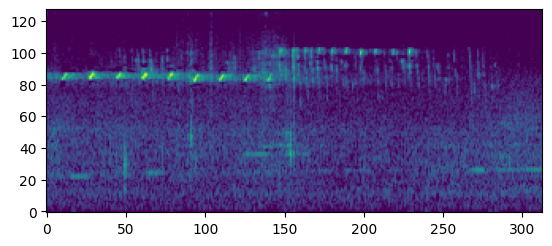

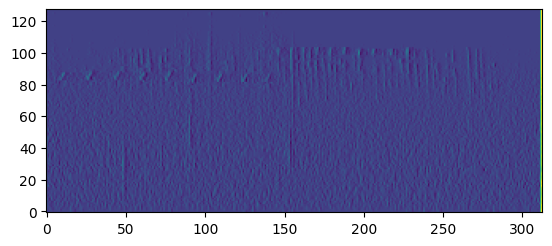

In [335]:
x1, x2 = get_diff_spectrogram(train_df['wav_path'].values[k], 1)
plt.imshow(x2, origin='lower')
plt.show()
plt.imshow(x1, origin='lower')

tensor(0.4148) tensor(-77.0043)


tensor(0.2547)


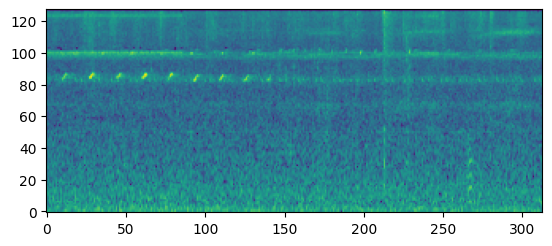

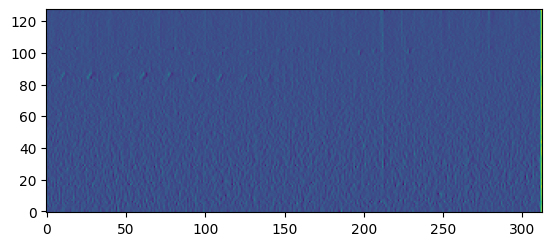

In [344]:
p = 1.5
tbackaud = Torch_BackgroundAugmentation(p, p, ex_df_val)
x1, x2 = get_diff_spectrogram(train_df['wav_path'].values[k], 1, use_b = True)
plt.imshow(x2, origin='lower')
plt.show()
plt.imshow(x1, origin='lower')

In [44]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        df,
        aud_augmentation = None,
        spec_augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.df = df.sample(frac=1., random_state = 42).reset_index(drop=True)
        self.aud_augmentation = aud_augmentation
        self.spec_augmentation = spec_augmentation
        self.mode = mode
#         self.labels = np.eye(182)[self.df["target"].astype(int).values]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        wav_path = self.df.wav_path.values[index]
        # target
        target = self.df.is_train[index]
        
        # load spec. data
        input_audio, sr = librosa.load(wav_path, sr = None) 
        
        # aug
        if(target == 1):
#             print(target, 'entrou')
            if self.aud_augmentation is not None:
        #             print(input_audio.shape)
                    input_audio = self.aud_augmentation(input_audio)
        
        input_spec = preprocess_fn('', input_audio = input_audio)
        
        if(target == 1):
            if self.spec_augmentation is not None:
                input_spec = self.spec_augmentation(image=input_spec)['image']
        
#         target
#         target = self.df[index]
        
        
        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)
#         return torch.tensor(input_spec, dtype=torch.float32) ,torch.tensor(target.astype(np.float32))

In [45]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
            albu.GaussNoise(var_limit=(0.001, 0.01), mean=0),
            albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
            albu.XYMasking(
                p=0.3,
                num_masks_x=(1, 5),
                num_masks_y=(1, 3),
                mask_x_length=(1, 20),
                mask_y_length=(1, 15),
            ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [46]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()

(256, 256)


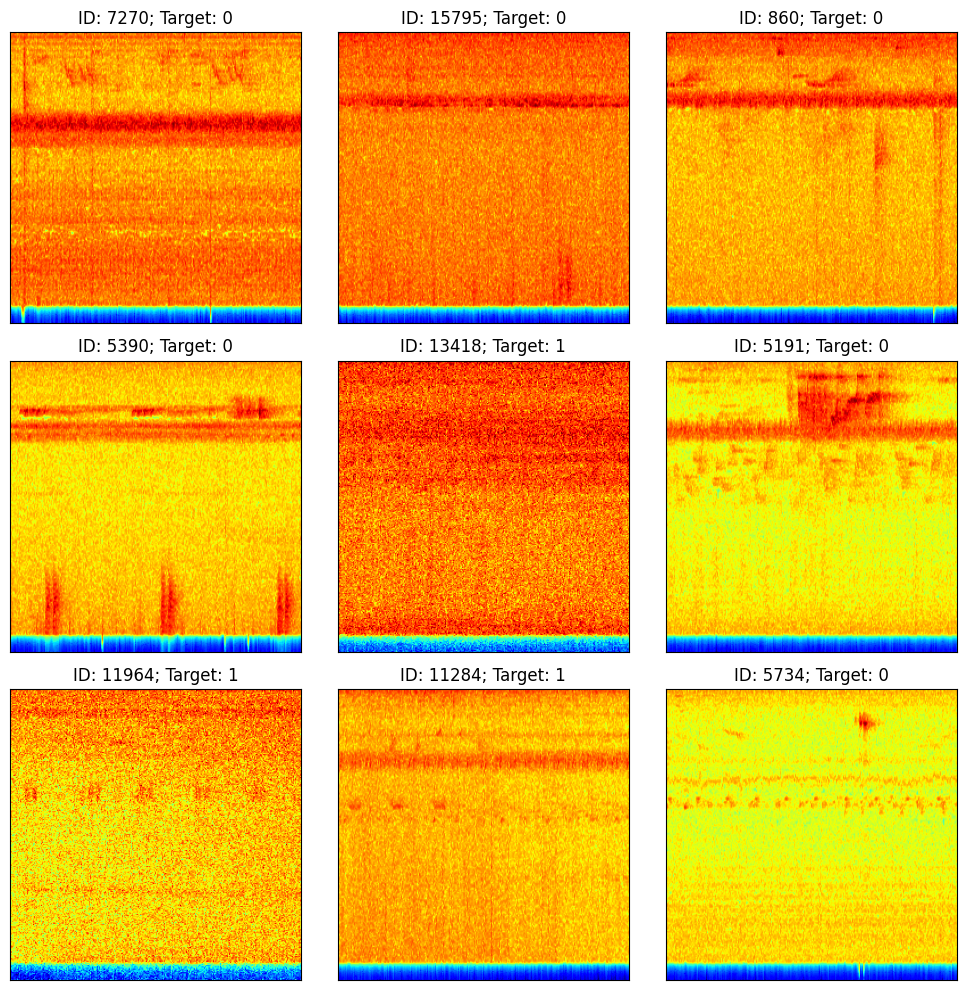

18031

In [47]:
dummy_dataset = BirdDataset(df_full, backaud , get_transforms('train'))

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)

show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

In [48]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_full, test_size = 0.15, random_state = 42, stratify=df_full['is_train'])
df_train.shape, df_val.shape

((13600, 2), (2400, 2))

In [49]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim
class Dvector(nn.Module):
    """LSTM-based d-vector with XCA attention."""

    def __init__(
        self,
        num_layers=3,
        dim_input=40,
        dim_cell=256,
        dim_emb=256,
        seg_len=160,
    ):
        super().__init__()
        self.lstm = nn.LSTM(dim_input, dim_cell, num_layers, batch_first=True)
        self.embedding = nn.Linear(dim_cell, dim_emb)
        self.linear = nn.Linear(dim_emb, 1)
        self.seg_len = seg_len
        self.classifier = nn.Linear(dim_emb, 2)

    def forward(self, inputs):
        """Forward a batch through network."""
        lstm_outs, _ = self.lstm(inputs)  # (batch, seg_len, dim_cell)
        embeds = torch.tanh(self.embedding(lstm_outs))  # (batch, seg_len, dim_emb)
#         embeds, _ = self.attn(embeds)
        attn_weights = F.softmax(self.linear(embeds), dim=1)
        embeds = torch.sum(embeds * attn_weights, dim=1)
        return self.classifier(embeds.div(embeds.norm(p=2, dim=-1, keepdim=True)))

In [50]:
# n = Dvector()

# x = torch.rand((1,64,40))

# out = n(x)
# out.shape

In [51]:
from torchvision.models import efficientnet

class EffNet(nn.Module):
    
    def __init__(self, pretrained=True):
        super().__init__()

        if pretrained: weights = efficientnet.EfficientNet_B0_Weights.DEFAULT
        else: weights = None
        self.base_model = efficientnet.efficientnet_b0(weights=weights)

        
        self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, 2, dtype=torch.float32)
    
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = x.expand(-1, 3, -1, -1)
        
        return self.base_model(x)

In [52]:
# n = EffNet()

# x = torch.rand((1,64,40))

# out = n(x)
# out.shape

In [53]:
from sklearn.metrics import roc_auc_score

In [54]:
# nn.Softmax(dim=1)(out).cpu().detach().numpy()[0][1]

In [55]:
# train_ds = BirdDataset(train_df, backaud, get_transforms('train'), 'train')
# val_ds = BirdDataset(df_val, backaud, get_transforms('valid'), 'valid')

# train_dl = torch.utils.data.DataLoader(
#     train_ds,
#     batch_size=CONFIG.batch_size,
#     shuffle=True, # If using sampler must be False
#     num_workers=CONFIG.n_workers,
#     pin_memory=True,
#     persistent_workers=True)
# #         sampler = sampler


In [56]:
# batch = next(iter(train_dl))

In [57]:
# out = n(batch[0])

In [58]:
# nn.Softmax(dim=1)(out).cpu().detach().numpy()[:,1]

In [59]:
# batch[1].cpu().detach().numpy().astype(int)

In [60]:
# roc_auc_score(batch[1].cpu().detach().numpy().astype(int), nn.Softmax(dim=1)(out).cpu().detach().numpy()[:,1])

In [61]:
from sklearn.metrics import accuracy_score

In [62]:
def run_training(model_type, train_df, val_df, augs_type='train', backaud=None):
    print('================================================================')
    print(f"==== Running training ====")
     
    if(CONFIG.device =='cuda'):
        print('using cuda')
    
    print(f'using augmentations:')
    print(get_transforms(augs_type))
    
    
    print(f'backaud = {backaud}')
    train_ds = BirdDataset(train_df, backaud, get_transforms(augs_type), 'train')
    val_ds = BirdDataset(val_df, backaud, get_transforms(augs_type), 'valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CONFIG.batch_size,
        shuffle=True, # If using sampler must be False
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True,
#         sampler = sampler
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        num_workers=CONFIG.n_workers,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    if(model_type == 'dvector'):
        bird_model = Dvector().cuda()
    else:
        bird_model = EffNet().cuda()
        
        
    optimizer = optim.Adam(bird_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    criterion = nn.CrossEntropyLoss().cuda()
        
    tr_losses = []
    tr_roc_auc = []
    tr_acc = []

    vl_losses = []
    vl_roc_auc = []
    vl_acc = []
    
    for epoch in range(CONFIG.epochs):
        total_loss = 0
        bird_model.train()
        all_targets = []
        all_preds = []
        for batch in tqdm(train_dl):
            outs = bird_model(batch[0].cuda())
            
            loss = criterion(outs, batch[1].cuda())
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            all_targets.append(batch[1].cpu().numpy())
            all_preds.append(outs.cpu().detach().numpy())  # Detach para evitar o rastreamento do grafo de computaçã
            

        all_targets = np.concatenate(all_targets)
        all_preds = np.concatenate(all_preds)

        # Calcular ROC AUC
        train_auc = roc_auc_score(all_targets, all_preds[:,1])
        train_acc = accuracy_score(all_targets, all_preds.argmax(axis = 1))
        train_avg_loss = total_loss/len(train_dl)
        
        tr_acc.append(train_acc)
        tr_roc_auc.append(train_auc)
        tr_losses.append(train_avg_loss)
        
        eval_loss = 0
        roc_auc = 0
        
        
        bird_model.eval()
        all_targets = []
        all_preds = []
        # End epoch run validation
        for batch in tqdm(val_dl):
            outs = bird_model(batch[0].cuda())
            
            loss = criterion(outs, batch[1].cuda())
            
            eval_loss += loss.item()
            
            all_targets.append(batch[1].cpu().numpy())
            all_preds.append(outs.cpu().detach().numpy())  # Detach para evitar o rastreamento do grafo de computaçã
            
            
        all_targets = np.concatenate(all_targets)
        all_preds = np.concatenate(all_preds)

        # Calcular ROC AUC
        eval_roc_auc = roc_auc_score(all_targets, all_preds[:,1])
        eval_acc = accuracy_score(all_targets, all_preds.argmax(axis = 1))
#         eval_roc_auc = metric/len(val_dl)
        eval_avg_loss = eval_loss/len(val_dl)


        vl_acc.append(eval_acc)
        vl_roc_auc.append(eval_roc_auc)
        vl_losses.append(eval_avg_loss)
    
        print("\n\n")
        print("--> EVAL PERFORMANCE")
        print(
            "   | > Epoch:{}  AvgLoss: {:.5f} AvgROCAUC: {:.5f} AvgACC {:.5f}".format(epoch, eval_avg_loss, eval_roc_auc, eval_acc),
            flush=True,
        )
        
        gc.collect()
        
    
    return_dict = {
        'train_losses': tr_losses,
        'train_acc': tr_acc,
        'train_roc': tr_roc_auc,
        'val_losses': vl_losses,
        'val_acc': vl_acc,
        'val_roc': vl_roc_auc
    }
    
    return return_dict, bird_model

In [63]:
def get_transforms(_type):
    
    if _type == 'train':
        return albu.Compose([
#             albu.GaussNoise(var_limit=(0.001, 0.01), mean=0),
#             albu.HorizontalFlip(0.5) if CONFIG.USE_XYMASKING else albu.NoOp(),
#             albu.XYMasking(
#                 p=0.3,
#                 num_masks_x=(1, 5),
#                 num_masks_y=(1, 3),
#                 mask_x_length=(1, 20),
#                 mask_y_length=(1, 15),
#             ) if CONFIG.USE_XYMASKING else albu.NoOp()
        ])
    elif _type == 'valid':
        return albu.Compose([])

In [75]:
backaud = BackgroundAugmentation(0.5,1, ex_df_val)
# backaud = None

In [76]:
import torch
import random
import numpy as np

def set_seed(seed):
    """Defina a semente para numpy, torch, e random."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Use a função para definir uma semente específica
set_seed(42)

metrics, model = run_training('dsf', df_train, df_val, augs_type='train', backaud = backaud)

==== Running training ====
using cuda
using augmentations:
Compose([
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
backaud = <__main__.BackgroundAugmentation object at 0x7fade9aae5e0>


100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.36it/s]




--> EVAL PERFORMANCE
   | > Epoch:0  AvgLoss: 16.28852 AvgROCAUC: 0.67388 AvgACC 0.59375



100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:10<00:00,  7.49it/s]




--> EVAL PERFORMANCE
   | > Epoch:1  AvgLoss: 10.45367 AvgROCAUC: 0.47425 AvgACC 0.49500



100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:09<00:00,  7.51it/s]




--> EVAL PERFORMANCE
   | > Epoch:2  AvgLoss: 4.09968 AvgROCAUC: 0.76779 AvgACC 0.65000



100%|███████████████████████████████████████████████████████████████████████████████████| 75/75 [00:09<00:00,  7.56it/s]




--> EVAL PERFORMANCE
   | > Epoch:3  AvgLoss: 4.26735 AvgROCAUC: 0.73591 AvgACC 0.60458
